# Pairs Trading Strategy

Pairs trading is a classic example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it. We'll start by constructing a toy example.

Useful link: 
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Integration_Cointegration_and_Stationarity/notebook.ipynb

In [35]:
#pip install qstrader

ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'C:\\Users\\lucac\\anaconda3\\Lib\\site-packages\\~andas.libs\\msvcp140-fa0758dedafbbe194d3ee96e3dc2b9a3.dll'
Consider using the `--user` option or check the permissions.




  Using cached qstrader-0.2.7-py3-none-any.whl (74 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-win_amd64.whl (7.7 MB)
  Using cached pandas-2.2.2-cp310-cp310-win_amd64.whl (11.6 MB)
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3


In [2]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
import statsmodels
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import json


## Looking for Cointegrated Pairs of .....
We use the cointegration because.......
Economic Relationship: Stocks of companies operating in the same industry or sector may exhibit cointegration because they are influenced by common economic factors, such as industry trends, market conditions, or macroeconomic variables. For example, two competing companies in the same sector may have prices that move in tandem over the long term due to shared industry dynamics.
so we have selected these companies of the same industry......
bloomberg????

In [20]:
import utils
from ib_insync import *
util.startLoop()

# Create a random client ID
rnd = random.randint(0, 100)

# Connect to IB
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=rnd)

# List of stock tickers
tickers = ['XOM', 'CVX', 'COP', 'EOG', 'SLB','MPC', 'PXD', 'PSX', 'EPD', 'OXY']

# Initialize an empty DataFrame
df = pd.DataFrame()

# Function to get historical data and return as DataFrame
def get_historical_data(ticker):
    contract = Stock(ticker, 'SMART', 'USD')
    bars = ib.reqHistoricalData(
        contract, endDateTime='', durationStr='30 D',
        barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True)
    # Convert to DataFrame
    myData = util.df(bars)
    if type(myData) == type(None):
        return pd.DataFrame()
    return myData[['date', 'close']].rename(columns={'close': ticker})

# Collect data for each ticker and merge into a single DataFrame
for ticker in tickers:
    ticker_data = get_historical_data(ticker)
    if ticker_data.empty:
        continue
    if df.empty:
        df = ticker_data
    else:
        df = pd.merge(df, ticker_data, on='date', how='outer')

#set first column (time) as index
df.set_index('date', inplace=True)

new_tickers = df.columns

# Show the final DataFrame
print(df)
print(new_tickers)

Error 200, reqId 9: No security definition has been found for the request, contract: Stock(symbol='PXD', exchange='SMART', currency='USD')


                              XOM     CVX     COP     EOG    SLB     MPC  \
date                                                                       
2024-04-17 09:30:00-04:00  119.12  157.31  129.90  134.01  51.86  204.69   
2024-04-17 10:00:00-04:00  118.77  157.34  129.26  133.81  51.59  203.99   
2024-04-17 11:00:00-04:00  118.19  156.80  128.69  132.38  51.33  203.34   
2024-04-17 12:00:00-04:00  117.64  156.42  128.43  132.16  51.09  202.21   
2024-04-17 13:00:00-04:00  118.51  156.96  128.75  133.07  51.15  203.10   
...                           ...     ...     ...     ...    ...     ...   
2024-05-28 13:00:00-04:00  114.21  158.25  118.54  124.88  46.52  178.55   
2024-05-28 14:00:00-04:00  114.58  158.86  118.83  125.57  46.58  179.10   
2024-05-28 15:00:00-04:00  114.89  159.05  118.97  125.84  46.54  179.14   
2024-05-29 09:30:00-04:00  113.84  157.57  115.03  123.44  45.79  174.44   
2024-05-29 10:00:00-04:00  113.64  157.09  114.74  123.51  45.63  175.06   

           

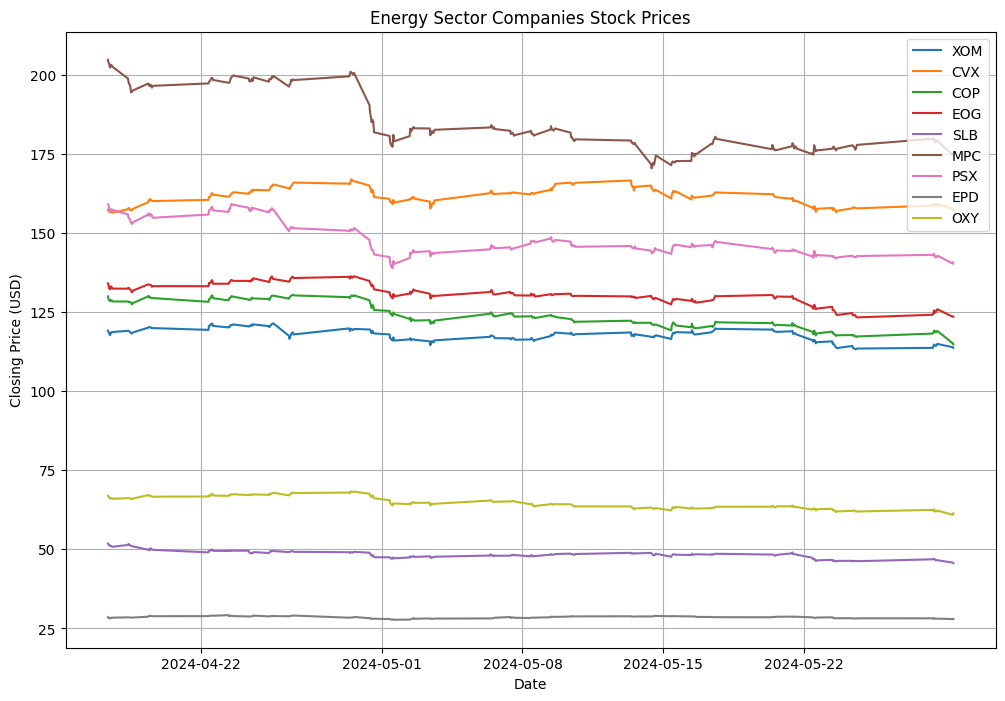

In [24]:
# Plot the charts
plt.figure(figsize=(12, 8))

for ticker in new_tickers:
    plt.plot(df.index, df[ticker], label=ticker)

# Add title and axis labels
plt.title('Energy Sector Companies Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


### ADF test:

In [25]:
# Function to perform the ADF test and print the results
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    # Check if the series is stationary or non-stationary
    if result[1] < 0.05:
        print(f'{name} is stationary')
    else:
        print(f'{name} is non-stationary')

# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Perform the ADF test for each ticker
for ticker in new_tickers:
    adf_test(daily_returns[ticker], ticker)

ADF Test for XOM:
Test Statistic: -14.506135643905104
p-value: 5.82499539803823e-27
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
XOM is stationary
ADF Test for CVX:
Test Statistic: -13.814189819416525
p-value: 8.126255412729768e-26
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
CVX is stationary
ADF Test for COP:
Test Statistic: -14.584213740055995
p-value: 4.418606239153503e-27
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
COP is stationary
ADF Test for EOG:
Test Statistic: -14.728144290092056
p-value: 2.6858321701788772e-27
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
EOG is stationary
ADF Test for SLB:
Test Statistic: -15.490821929886136
p-value: 2.48621246456769e-28
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
SLB is stationary
A

### CADF test:

In [26]:
# Function to perform the CADF test and print the results
def cadf_test(series1, series2, name1, name2):
    
    # Add a constant to the independent variable (series1)
    #X = np.column_stack((series1, np.ones(len(series1))))
    
    # Fit the linear regression model
    model = OLS(series2, series1)
    results = model.fit()
    # Get the residuals
    residuals = results.resid
    # Perform ADF test on the residuals
    adf_results = adfuller(residuals)
    print(f'CADF Test between {name1} and {name2}:')
    print('Test Statistic:', adf_results[0])
    print('p-value:', adf_results[1])
    print('Critical Values:')
    for key, value in adf_results[4].items():
        print(f'   {key}: {value}')
    # Check if the residuals are stationary
    if adf_results[1] < 0.05:
        print(f'The series {name1} and {name2} are cointegrated')
    else:
        print(f'The series {name1} and {name2} are not cointegrated')

# Perform the CADF test for each pair of tickers
for i in range(len(new_tickers)):
    for j in range(i+1, len(new_tickers)):
        cadf_test(daily_returns[new_tickers[i]], daily_returns[new_tickers[j]], new_tickers[i], new_tickers[j])



CADF Test between XOM and CVX:
Test Statistic: -13.751419212414927
p-value: 1.0488100030499197e-25
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
The series XOM and CVX are cointegrated
CADF Test between XOM and COP:
Test Statistic: -14.268952029243167
p-value: 1.384926565951254e-26
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
The series XOM and COP are cointegrated
CADF Test between XOM and EOG:
Test Statistic: -7.308042443030191
p-value: 1.2859944239351766e-10
Critical Values:
   1%: -3.463476079125
   5%: -2.876102355
   10%: -2.574532225
The series XOM and EOG are cointegrated
CADF Test between XOM and SLB:
Test Statistic: -15.022135419112193
p-value: 1.0186842503557066e-27
Critical Values:
   1%: -3.462980134086401
   5%: -2.875885461947131
   10%: -2.5744164898444515
The series XOM and SLB are cointegrated
CADF Test between XOM and MPC:
Test Statistic: -13.311473234354317
p-value

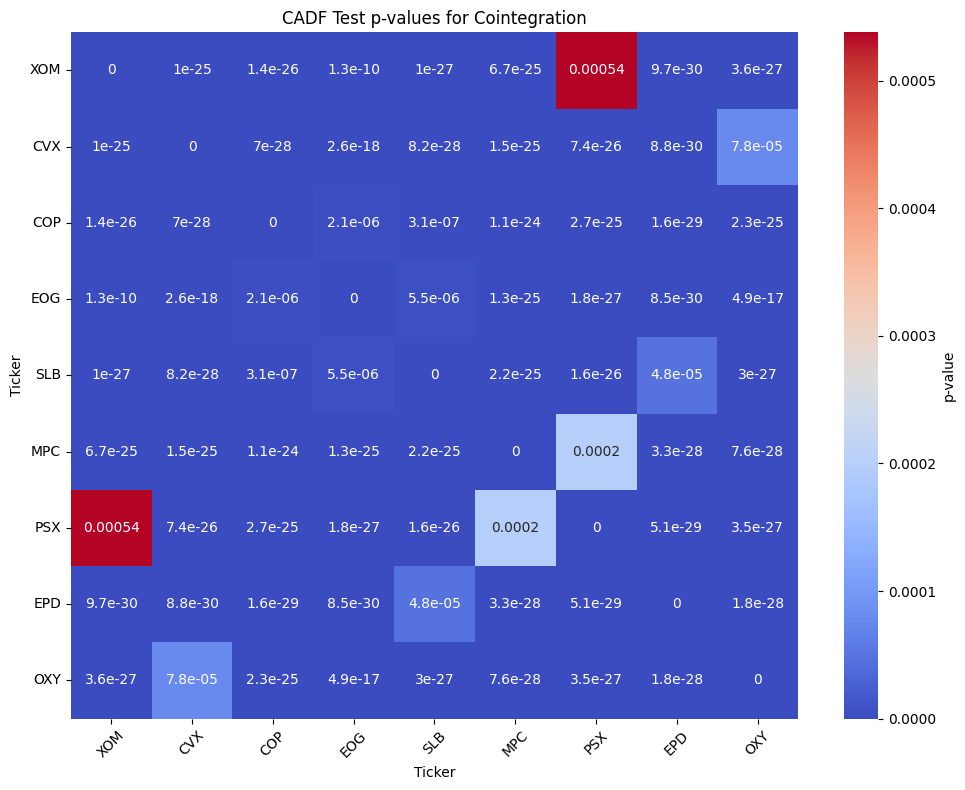

In [27]:
# Initialize an empty matrix to store p-values
p_values_matrix = np.zeros((len(new_tickers), len(new_tickers)))

# Function to perform the CADF test and populate the p-values matrix
def cadf_test(series1, series2, i, j):
    # Add a constant to the independent variable (series1)
    X = np.column_stack((series1, np.ones(len(series1))))
    # Fit the linear regression model
    model = OLS(series2, X)
    results = model.fit()
    # Get the residuals
    residuals = results.resid
    # Perform ADF test on the residuals
    adf_results = adfuller(residuals)
    # Store the p-value in the matrix
    p_values_matrix[i, j] = adf_results[1]
    p_values_matrix[j, i] = adf_results[1]  # Since the matrix is symmetric

# Perform the CADF test for each pair of tickers
for i in range(len(new_tickers)):
    for j in range(i+1, len(new_tickers)):
        cadf_test(daily_returns[new_tickers[i]], daily_returns[new_tickers[j]], i, j)

# Create a heatmap of the p-values matrix
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_matrix, annot=True, xticklabels=new_tickers, yticklabels=new_tickers, cmap='coolwarm', cbar_kws={'label': 'p-value'})
plt.title('CADF Test p-values for Cointegration')
plt.xlabel('Ticker')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Best cointegrated pair:

In [28]:
best_pair = None
lowest_pvalue = float('inf')  # Initialize with a very high value

# Function to perform the CADF test and print the results
def cadf_test(series1, series2, name1, name2):
    global best_pair, lowest_pvalue
    
    # Add a constant to the independent variable (series1)
    X = np.column_stack((series1, np.ones(len(series1))))
    # Fit the linear regression model
    model = OLS(series2, X)
    results = model.fit()
    # Get the residuals
    residuals = results.resid
    # Perform ADF test on the residuals
    adf_results = adfuller(residuals)
    # Check if the residuals are stationary
    if adf_results[1] < lowest_pvalue:
        best_pair = (name1, name2)
        lowest_pvalue = adf_results[1]

# Perform the CADF test for each pair of tickers
for i in range(len(new_tickers)):
    for j in range(i+1, len(new_tickers)):
        cadf_test(daily_returns[new_tickers[i]], daily_returns[new_tickers[j]], new_tickers[i], new_tickers[j])

# Print the best cointegrated pair
if best_pair:
    print(f"The best cointegrated pair is: {best_pair[0]} and {best_pair[1]} with p-value: {lowest_pvalue}")
else:
    print("No cointegrated pair found.")


The best cointegrated pair is: EOG and EPD with p-value: 8.479017545922913e-30


In [31]:
# Prezzi delle azioni di EDG e EPD
asset_1 = df['EOG']
asset_2 = df['EPD']

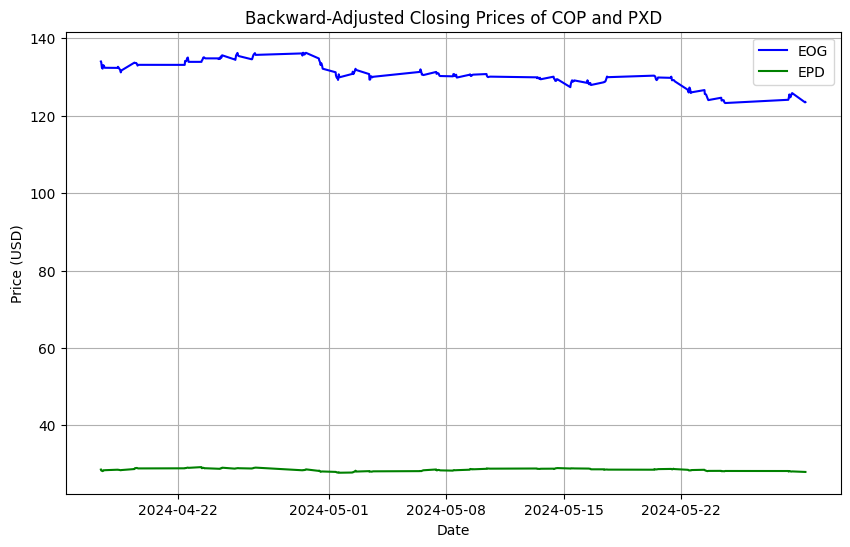

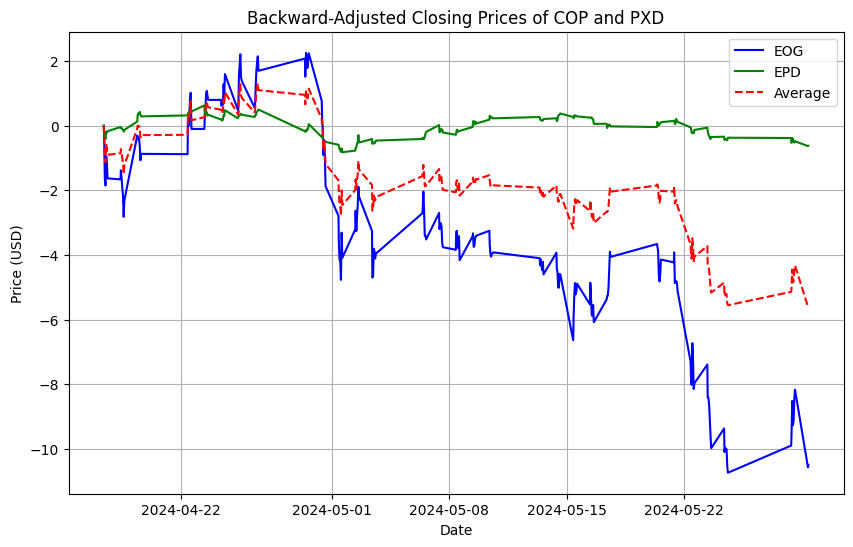

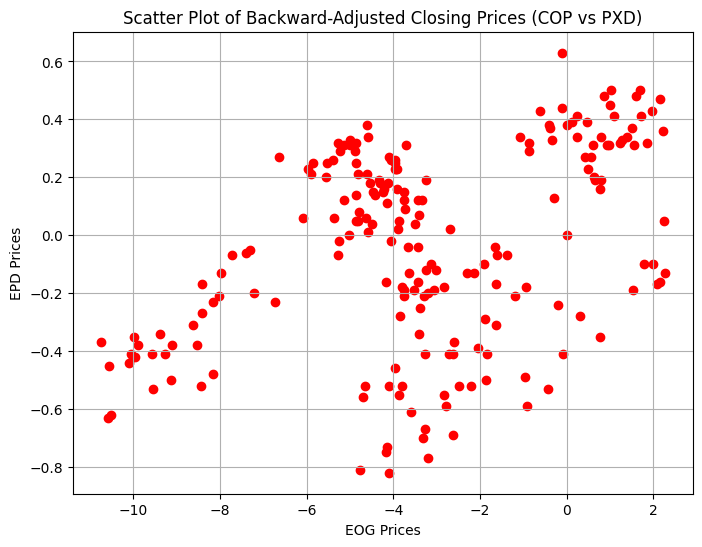

In [32]:
# Grafico dei backward-adjusted closing prices
plt.figure(figsize=(10, 6))
plt.plot(asset_1, label='EOG', color='blue')
plt.plot(asset_2, label='EPD', color='green')
plt.title('Backward-Adjusted Closing Prices of COP and PXD')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the average between COP and PXD
average_prices = (asset_1 + asset_2) / 2

# Setting initial prices to 0
asset_1 -= asset_1.iloc[0]
asset_2 -= asset_2.iloc[0]
average_prices -= average_prices.iloc[0]

# Grafico dei backward-adjusted closing prices
plt.figure(figsize=(10, 6))
plt.plot(asset_1, label='EOG', color='blue')
plt.plot(asset_2, label='EPD', color='green')
plt.plot(average_prices, label='Average', color='red', linestyle='--')
plt.title('Backward-Adjusted Closing Prices of COP and PXD')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot dei backward-adjusted closing prices
plt.figure(figsize=(8, 6))
plt.scatter(asset_1, asset_2, color='red')
plt.title('Scatter Plot of Backward-Adjusted Closing Prices (COP vs PXD)')
plt.xlabel('EOG Prices')
plt.ylabel('EPD Prices')
plt.grid(True)
plt.show()


### Optimized entry - exit

In [13]:
# Define the stock symbols for ConocoPhillips and ExxonMobil
tickers = ["COP", "XOM"]

# Set the date range
start_date = "2015-01-01"
end_date = "2022-12-31"

# Download the stock data
stock_data = yf.download(tickers, start=start_date, end=end_date)

# Separate the data into two dataframes
S1 = stock_data['Adj Close']['COP'].copy()
S2 = stock_data['Adj Close']['XOM'].copy()

# Display the data for ConocoPhillips renamed as S1
print("Data for S1 (ConocoPhillips):")
print(S1)

# Display the data for ExxonMobil renamed as S2
print("\nData for S2 (ExxonMobil):")
print(S2)



[*********************100%***********************]  2 of 2 completed
Data for S1 (ConocoPhillips):
Date
2015-01-02     50.996063
2015-01-05     48.569107
2015-01-06     46.563892
2015-01-07     46.874660
2015-01-08     48.043747
                 ...    
2022-12-23    112.096992
2022-12-27    113.456894
2022-12-28    110.430611
2022-12-29    111.464920
2022-12-30    113.006783
Name: COP, Length: 2014, dtype: float64

Data for S2 (ExxonMobil):
Date
2015-01-02     61.518940
2015-01-05     59.835667
2015-01-06     59.517540
2015-01-07     60.120632
2015-01-08     61.121315
                 ...    
2022-12-23    104.124245
2022-12-27    105.570953
2022-12-28    103.836815
2022-12-29    104.622444
2022-12-30    105.676338
Name: XOM, Length: 2014, dtype: float64


C:\Users\lucac\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\lucac\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [14]:
# Define the constant B, specify your value for B
B = 1  # Change this to the desired value

# Compute Xt
Xt = S1 - B * S2

# Display the new series Xt
print("Computed Series Xt:")
print(Xt)


Computed Series Xt:
Date
2015-01-02   -10.522877
2015-01-05   -11.266560
2015-01-06   -12.953648
2015-01-07   -13.245972
2015-01-08   -13.077568
                ...    
2022-12-23     7.972748
2022-12-27     7.885941
2022-12-28     6.593796
2022-12-29     6.842476
2022-12-30     7.330444
Length: 2014, dtype: float64


Estimation of teta, mu, sigma:

[*********************100%***********************]  2 of 2 completed

C:\Users\lucac\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\lucac\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Optimized parameters:
Theta: 0.008868453668875566, Mu: 17.411410791100103, Sigma: 0.762535564757952


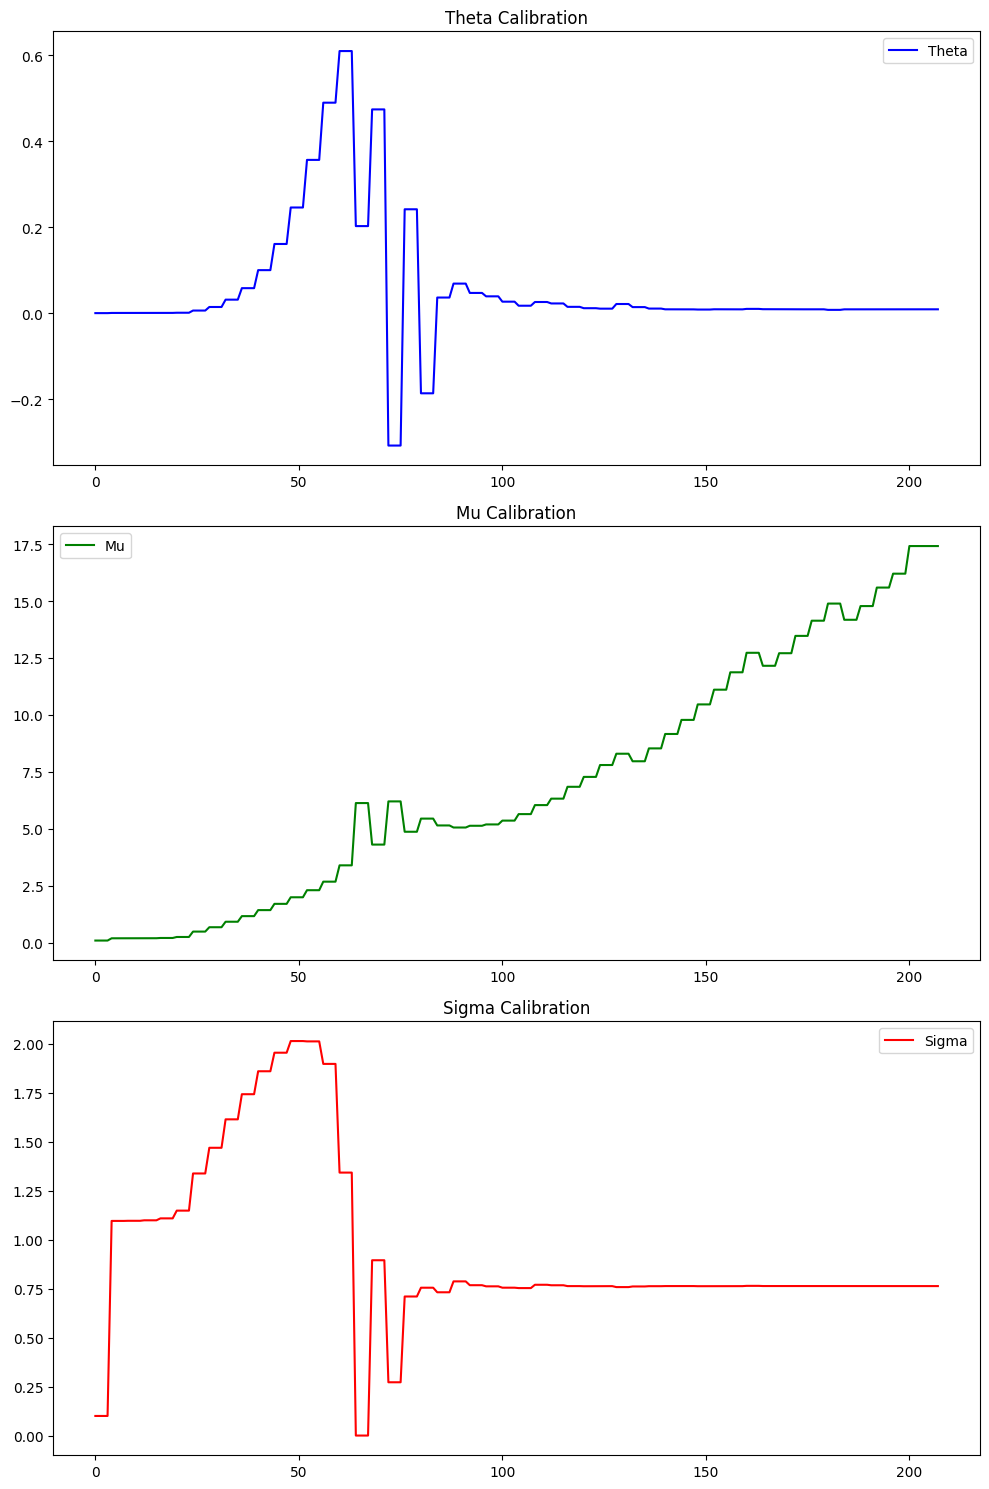

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf

# Function to calculate the log-likelihood of OU process
def log_likelihood(params, data):
    theta, mu, sigma = params
    n = len(data)
    delta_t = 1  # Assuming daily data, adjust if different sampling rate
    differences = np.diff(data)
    expected_values = data[:-1] * np.exp(-mu * delta_t) + theta * (1 - np.exp(-mu * delta_t))
    residuals = differences - expected_values
    ll = -0.5 * n * np.log(2 * np.pi) - n * np.log(sigma) - 0.5 / (sigma**2) * np.sum(residuals**2)
    parameter_trace.append(params)  # Append current parameters to trace
    return -ll  # Negative LL for minimization

# List to store parameter values during optimization
parameter_trace = []

# Define the stock symbols and date range
tickers = ["COP", "XOM"]
start_date = "2015-01-01"
end_date = "2022-12-31"

# Fetch the stock data
data = yf.download(tickers, start=start_date, end=end_date)

# Calculate portfolio value Xt
S1 = data['Adj Close']['COP']
S2 = data['Adj Close']['XOM']
Xt = S1 - 1 * S2  # Assuming B=1 for this example, adjust as necessary

# Initial parameter guesses and bounds
initial_params = [0.0, 0.1, 0.1]  # Initial guesses for theta, mu, sigma
bounds = [(None, None), (1e-5, None), (1e-5, None)]  # Constraints to ensure positive mu and sigma

# Minimize the negative log-likelihood
result = minimize(log_likelihood, initial_params, args=(Xt.values,), bounds=bounds)

# Optimized parameters
theta_opt, mu_opt, sigma_opt = result.x

# Output the optimized parameters
print("Optimized parameters:")
print(f"Theta: {theta_opt}, Mu: {mu_opt}, Sigma: {sigma_opt}")

# Extract parameter traces
thetas, mus, sigmas = zip(*parameter_trace)

# Plotting the parameters
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].plot(thetas, label='Theta', color='blue')
ax[0].set_title('Theta Calibration')
ax[0].legend()

ax[1].plot(mus, label='Mu', color='green')
ax[1].set_title('Mu Calibration')
ax[1].legend()

ax[2].plot(sigmas, label='Sigma', color='red')
ax[2].set_title('Sigma Calibration')
ax[2].legend()

plt.tight_layout()
plt.show()


B=argmaxB(l):

In [22]:
# Define a range of B values to optimize over
B_values = np.linspace(-2, 2, 100)  # Adjust the range and count as needed

# Search for the optimal B
max_log_likelihood = -np.inf
optimal_B = None
for B in B_values:
    Xt = S1 - B * S2
    ll = log_likelihood([theta_opt, mu_opt, sigma_opt], Xt.values)
    if ll > max_log_likelihood:
        max_log_likelihood = ll
        optimal_B = B

# Display the optimal B
print("Optimal B (B_t):", optimal_B)


Optimal B (B_t): -2.0
